# "Quick, Draw!" GAN

* code based directly on [Grant Beyleveld's](https://github.com/grantbey/quickdraw-GAN/blob/master/octopus-v1.0.ipynb), which is derived from [Rowel Atienza's](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) under [MIT License](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE)
* data provided by [Google](https://github.com/googlecreativelab/quickdraw-dataset) under [Creative Commons Attribution 4.0 license](https://creativecommons.org/licenses/by/4.0/)

#### Load dependencies

In [1]:
import numpy as np
import h5py

# JK NOTE: Check that all these dependencies are used
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, AveragePooling2D, Reshape, Dense, BatchNormalization, Dropout, Flatten, UpSampling2D, Conv2DTranspose
from keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Load data

* NumPy bitmap files [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap)

In [2]:
data = np.load('../quickdraw/apple.npy') # PICK YOUR OWN!
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

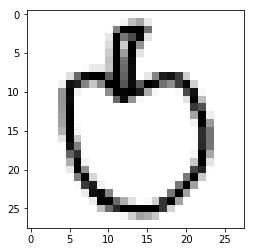

In [8]:
plt.imshow(data[42000,:,:,0], cmap='Greys')

In [16]:
def discriminator_builder(width=64, dropout_prop=0.4):
    
    model = Sequential()
    
    # convolutional layers
    model.add(Conv2D(width, 5, strides=2, padding='same', activation='relu', input_shape=(img_w,img_h,1)))
    model.add(Dropout(dropout_prop))
    
    model.add(Conv2D(width*2, 5, strides=2, padding='same', activation='relu'))
    model.add(Dropout(dropout_prop))
    
    model.add(Conv2D(width*4, 5, strides=2, padding='same', activation='relu'))
    model.add(Dropout(dropout_prop))
    
    model.add(Conv2D(width*8, 5, strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_prop))
    
    # output layer
    model.add(Flatten())    
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

In [22]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [27]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0002, decay=6e-8), metrics=['accuracy'])

In [20]:
def generator_builder(z_dim=100, width=64, dropout_prop=0.4):
    # has four deconv layers that mirror the discriminator's four conv layers
    
    model = Sequential()
    
    # dense layer
    square_length = 7
    model.add(Dense(square_length*square_length*width, activation='relu', input_shape=(z_dim,)))
    model.add(BatchNormalization(axis=-1, momentum=0.9))
    model.add(Reshape((square_length,square_length,width)))
    model.add(Dropout(dropout_prop))
    
    # convolutional layers
    
    model.add(UpSampling2D()) # default is (2,2), mirroring discriminator's stride length of two
    model.add(Conv2DTranspose(int(width/2), kernel_size=5, activation='relu')) # a.k.a. "deconvolution" layer
    model.add(BatchNormalization(axis=-1,momentum=0.9))
    
    model.add(UpSampling2D()) 
    model.add(Conv2DTranspose(int(width/4), kernel_size=5, activation='relu')) # a.k.a. "deconvolution" layer
    model.add(BatchNormalization(axis=-1,momentum=0.9))
    
#     model.add(UpSampling2D()) # why comment out?
    model.add(Conv2DTranspose(int(width/8), kernel_size=5, activation='relu')) # a.k.a. "deconvolution" layer
    model.add(BatchNormalization(axis=-1,momentum=0.9))
    
    model.add(Conv2D(1, kernel_size=5, padding='same', activation='sigmoid'))
    
    model.summary()
    
    return model

In [24]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_6 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 18, 18, 32)        51232     
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 18, 32)        128       
__________

In [28]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'])
    
    model.summary()
    
    return model

In [29]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 44, 44, 1)         396961    
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [35]:
# def train(n_training_steps=2000, batch=128): 

# for i in range(n_training_steps):
batch=128
for i in range(1):

    real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)], (batch,28,28,1))
    fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

    x = np.concatenate((real_imgs, fake_imgs))
    y_discriminator = np.ones([2*batch,1])
    y_discriminator[batch:,:] = 0
    d_loss = discriminator.train_on_batch(x,y_discriminator)

    noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
    y = np.ones([batch,1])
    a_loss = adversarial_model.train_on_batch(noise,y)

    log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
    log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
    print(log_mesg)

    if (i+1)%1000 == 0:

        print('Step #{}'.format(i+1))
        log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
        log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
        print(log_mesg)

        noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
        gen_imgs = generator.predict(noise)

        plt.figure(figsize=(5,5))
        for k in range(gen_imgs.shape[0]):
            plt.subplot(4, 4, k+1)
            plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.savefig('./gan_images/run1_{}.png'.format(i+1))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [31]:
train(n_training_steps=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly